In [1]:
import numpy as np
import pandas as pd
import torch
import os
import argparse
from rdkit import RDLogger, Chem
from rdkit.Chem import Draw
import yaml

from seq_graph_retro.utils.edit_mol import canonicalize, generate_reac_set
from seq_graph_retro.models import EditLGSeparate
from seq_graph_retro.search import BeamSearch,BeamNode
from seq_graph_retro.molgraph import MultiElement
lg = RDLogger.logger()
lg.setLevel(4)


In [2]:
############################# 路径定义
try:
    ROOT_DIR = os.environ["SEQ_GRAPH_RETRO"]    #/home/wuhexing/GraphRetro
    DATA_DIR = os.path.join(ROOT_DIR, "datasets", "uspto-50k")
    EXP_DIR = os.path.join(ROOT_DIR, "models")

except KeyError:
    ROOT_DIR = "./"
    DATA_DIR = os.path.join(ROOT_DIR, "datasets", "uspto-50k")
    EXP_DIR = os.path.join(ROOT_DIR, "models")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEFAULT_TEST_FILE = f"{DATA_DIR}/canonicalized_test.csv"

print('DATA_DIR',DATA_DIR,'EXP_DIR',EXP_DIR)

DATA_DIR ./datasets\uspto-50k EXP_DIR ./models


In [3]:
def canonicalize_prod(p):
    pcanon = canonicalize(p)
    pmol = Chem.MolFromSmiles(pcanon)
    [atom.SetAtomMapNum(atom.GetIdx()+1) for atom in pmol.GetAtoms()]
    p = Chem.MolToSmiles(pmol)
    return p

def check_nodes_complete(node_list):
    for node in node_list:
        if not node.node_complete:
            return False
    return True

def map_value_to_category(value):
    if 0 <= value <= 24:
        return 0
    elif 25 <= value <= 49:
        return 1
    elif 50 <= value <= 74:
        return 2
    elif 75 <= value <= 99:
        return 3
    elif 100 <= value <= 124:
        return 4  # 这里应该是4，而不是3
    else:
        return None
# 【编辑】模型
def load_edits_model(args):
    edits_step = args.edits_step  # edits_step =  epoch_156
    if edits_step is None:
        edits_step = "best_model"
    if "run" in args.edits_exp:  # SingleEdit_10-02-2021--08-44-37
        # This addition because some of the new experiments were run using wandb
        edits_loaded = torch.load(os.path.join(args.exp_dir, "wandb", args.edits_exp, "files", edits_step + ".pt"), map_location=DEVICE)
        with open(f"{args.exp_dir}/wandb/{args.edits_exp}/files/config.yaml", "r") as f:
            tmp_loaded = yaml.load(f, Loader=yaml.FullLoader)

        model_name = tmp_loaded['model']['value']
    else:
        edits_loaded = torch.load(os.path.join(args.exp_dir, args.edits_exp,
                                  "checkpoints", edits_step + ".pt"),
                                  map_location=DEVICE)  #  ./models/SingleEdit_10-02-2021--08-44-37/checkpoints/epoch_156.pt
        model_name = args.edits_exp.split("_")[0]  # model_name = SingleEdit
    return edits_loaded, model_name     # edits_loaded包含模型主体

# 【离去】模型
def load_lg_model(args):
    lg_step = args.lg_step  # step_101951
    if lg_step is None:
        lg_step = "best_model"
    if "run" in args.lg_exp:
        # This addition because some of the new experiments were run using wandb
        lg_loaded = torch.load(os.path.join(args.exp_dir, "wandb", args.lg_exp, "files", lg_step + ".pt"), map_location=DEVICE)
        with open(f"{args.exp_dir}/wandb/{args.lg_exp}/files/config.yaml", "r") as f:
            tmp_loaded = yaml.load(f, Loader=yaml.FullLoader)
        model_name = tmp_loaded['model']['value']
    else:
        lg_loaded = torch.load(os.path.join(args.exp_dir, args.lg_exp,
                               "checkpoints", lg_step + ".pt"),
                                map_location=DEVICE)  # models/LGIndEmbed_18-02-2021--12-23-26/checkpoints/step_101951.pt
        model_name = args.lg_exp.split("_")[0]  # model_name = LGIndEmbed
    return lg_loaded, model_name

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--data_dir", default=DATA_DIR, help="Data directory")
parser.add_argument("--exp_dir", default=EXP_DIR, help="Experiments directory.")
parser.add_argument("--test_file", default=DEFAULT_TEST_FILE, help="Test file.")
parser.add_argument("--edits_exp", default="SingleEdit_10-02-2021--08-44-37",help="Name of edit prediction experiment.")
parser.add_argument("--edits_step", default="epoch_156",help="Checkpoint for edit prediction experiment.")
parser.add_argument("--lg_exp", default="LGIndEmbed_18-02-2021--12-23-26",help="Name of synthon completion experiment.")
parser.add_argument("--lg_step", default="step_101951",help="Checkpoint for synthon completion experiment.")
#beam_search 参数设置
parser.add_argument("--beam_width", default=5, type=int, help="Beam width")
parser.add_argument("--use_rxn_class", action='store_true', help="Whether to use reaction class.")
parser.add_argument("--rxn_class_acc", action="store_true",help="Whether to print reaction class accuracy.")
args, unknown = parser.parse_known_args()   #用一个unknown忽略不认识的参数
test_df = pd.read_csv(args.test_file)    #读入测试文件

edits_loaded, edit_net_name = load_edits_model(args)    #加载图编辑预测模型
lg_loaded, lg_net_name = load_lg_model(args)            #加载离去基团选择模型

# 从加载的模型中提取配置数据
edits_config = edits_loaded["saveables"]
lg_config = lg_loaded['saveables']
lg_toggles = lg_config['toggles']

print('edit_config:',edits_config)
print('lg_config:',lg_config)
print('lg_toggles:',lg_toggles)


edit_config: {'config': {'n_atom_feat': 98, 'n_bond_feat': 6, 'n_bin_feat': 11, 'rnn_type': 'gru', 'mpn_size': 256, 'mlp_size': 512, 'depth': 10, 'bias': False, 'edit_loss': 'sigmoid', 'bs_outdim': 5, 'bond_label_feat': 109, 'dropout_mlp': 0.3, 'dropout_mpn': 0.15, 'pos_weight': 5.0}, 'encoder_name': 'GraphFeatEncoder', 'toggles': {'use_attn': False, 'use_h_labels': True, 'use_prod': True, 'use_nei': False, 'propagate_logits': True}}
lg_config: {'config': {'rnn_type': 'gru', 'mpn_size': 300, 'mlp_size': 300, 'depth': 10, 'bias': False, 'embed_size': 200, 'dropout_mlp': 0.3, 'dropout_mpn': 0.15, 'n_mt_blocks': 2, 'n_atom_feat': 98, 'n_bond_feat': 6, 'n_heads': 4, 'embed_bias': False}, 'lg_vocab': <seq_graph_retro.molgraph.vocab.Vocab object at 0x0000026ED75488E0>, 'encoder_name': 'GraphFeatEncoder', 'toggles': {'use_attn': False, 'use_prev_pred': True, 'use_rxn_class': False}}
lg_toggles: {'use_attn': False, 'use_prev_pred': True, 'use_rxn_class': False}


C:\Users\happyelements\AppData\Local\Temp\ipykernel_22888\15097730.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edits_loaded = torch.load(os.path.join(args.exp_dir, 

In [5]:
if 'tensor_file' in lg_config:  #这里是false
    print('ok')
    if not os.path.isfile(lg_config['tensor_file']):
        if not lg_toggles.get("use_rxn_class", False):
            tensor_file = os.path.join(args.data_dir, "train/h_labels/without_rxn/lg_inputs.pt")
        else:
            tensor_file = os.path.join(args.data_dir, "train/h_labels/with_rxn/lg_inputs.pt")
        lg_config['tensor_file'] = tensor_file

In [6]:
rm = EditLGSeparate(edits_config=edits_config, lg_config=lg_config, edit_net_name=edit_net_name,
                        lg_net_name=lg_net_name, device=DEVICE)  # 添加配置信息
rm.load_state_dict(edits_loaded['state'], lg_loaded['state'])    # 加载模型信息  加载模型的权重和状态

rm.to(DEVICE)  # 将模型移动到指定的设备（CPU 或 GPU）
rm.eval()   #设置模型为评估模式
n_matched = np.zeros(args.beam_width)   #beam_size,默认为10
width_nub = args.beam_width
print('束搜索宽度',args.beam_width)

beam_model = BeamSearch(model=rm, beam_width=args.beam_width, max_edits=1)  #加载束搜索模型

束搜索宽度 5


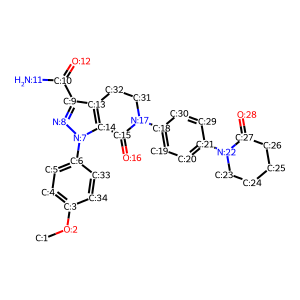

In [19]:
smiles = ['COC1=CC=C(N2N=C(C3=C2C(N(C4=CC=C(N5CCCCC5=O)C=C4)CC3)=O)C(N)=O)C=C1']
smiles[0] = canonicalize_prod(smiles[0])
img = Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in smiles], molsPerRow=1, subImgSize=(300, 300))
display(img)

In [20]:
# smiles = ['CCNC(=O)CCC/C=C\C[C@H]1[C@H](C[C@H]([C@@H]1/C=C/[C@H](CCC2=CC=CC=C2)O)O)O']
smiles = ['COC1=CC=C(N2N=C(C3=C2C(N(C4=CC=C(N5CCCCC5=O)C=C4)CC3)=O)C(N)=O)C=C1']
rxn=[]
rxn1=[]
rxn2=[]
for id,smile in enumerate(smiles):
    p = canonicalize_prod(smile)  # 清理 + 重新编码
    rxn.append(p)   #将产物加入到列表中
    mol=Chem.MolFromSmiles(p)
    # node_list=beam_model.run_edit_step(p)  # 预测反应中心
    node_list=[]
    node_list.append(BeamNode(mol=Chem.Mol(mol)))     # [BeamNode(mol=Chem.Mol(mol))
    node_list[0].edit=['6:7:1.0:0.0']
    edit_2 = '17:18:1.0:0.0'
    # print('模型预测的断键：',node_list[0].edit)
    new_node_list = []
    step = 0
    new_node,fragments_new2 = beam_model._create_lg_node(p, node_list[0], rxn_class=None)   # 增加了两个特征向量（一个关于合成子frag_vecs，一个关于产物prod_vecs），合成子个数
    new_node_list.append(new_node)

    # 第二次拆分的 【键】
    a1,a2,b1,b2 = edit_2.split(':')
    a1, a2, b1, b2 = int(a1), int(a2), float(b1), float(b2)

    while not check_nodes_complete(new_node_list) and step <= 6:
        tmp_list = []
        assert all([node.frag_vecs is not None for node in new_node_list])
        for node in new_node_list:
            tmp_list.extend(beam_model.add_lg_to_node(node))    # 预测离去基团，并添加至node中
        new_node_list = tmp_list
        step += 1

    step = 0
    tmp_list1 = tmp_list[:25]
    tmp_list1 = beam_model.keep_topk_nodes(tmp_list1)   # 选最靠谱的 5 个
    tmp_list2 = []  # 从第一次合成子

    frag_1 = []
    frag_2 = []
    frag_FirstToSecond = []  # 保存第二次要拆的合成子的smiles，带编号

    for beam_idx, node in enumerate(tmp_list1):
        pred_edit = node.edit
        pred_label = node.lg_groups
        print(beam_idx,"预测的离去基团的结果",pred_label)

        if isinstance(pred_edit, list): #检查pre_edit是否为一个列表，如果是，执行下面语句
            pred_edit = pred_edit[0]
        try:
            pred_set,reac_smi_no_canonicalize = generate_reac_set(p, pred_edit, pred_label, verbose=False)  # 生成预测的反应物集合
        except BaseException as e:
            print(e, flush=True)
            pred_set = None

        pred_list=list(pred_set)  # 反应集转换为列表，并打印结果
        print('pred_list',pred_list)

        # 判断第二次断键所在的合成子：读取合成子们的原子标签，然后和指定标签对比
        frag_1 = reac_smi_no_canonicalize.split('.')  # frag_1保存合成子的smiles
        frag_2 = [Chem.MolFromSmiles(smi) for smi in frag_1]
        try:    # 生成的结果转化为mol后为None，跳过
            frag_amaps = [set([atom.GetAtomMapNum() for atom in mol.GetAtoms()])
                            for mol in frag_2]
        except BaseException as e:
            print(e, flush=True)
            continue
        # 判断第二次断键的片段在哪个合成子中，对其直接进行第二次断键
        if a1 in frag_amaps[0] and a2 in frag_amaps[0]:
            print('frag_amaps[0]')
            sml = frag_1[0]
            frag_FirstToSecond.append(sml)
            mol = Chem.MolFromSmiles(sml)
            node_list.append(BeamNode(mol=Chem.Mol(mol)))
            node_list[1].edit = [edit_2]
            new_node, _ = beam_model._create_lg_node(sml, node_list[1], rxn_class=None)
            tmp_list2.append(new_node)
        elif a1 in frag_amaps[1] and a2 in frag_amaps[1]:
            print('frag_amaps[1]')
            # sml = canonicalize_prod(fragments_new2[0][1])
            sml = frag_1[1]
            frag_FirstToSecond.append(sml)
            mol = Chem.MolFromSmiles(sml)
            node_list.append(BeamNode(mol=Chem.Mol(mol)))
            node_list[1].edit = [edit_2]
            new_node, _ = beam_model._create_lg_node(sml, node_list[1], rxn_class=None)
            tmp_list2.append(new_node)
        print('第二次断键选择的第一次的合成子sml',sml)

        if len(pred_list)>1:
            rxn1.append(pred_list[0]+'.'+pred_list[1])
        else:
            rxn1.append(pred_list[0])

    frag_FirstToSecond_new =[canonicalize(x) for x in frag_FirstToSecond]

    # 束搜索匹配离去基团，关键参数 tmp_list2    开始有5个，然后扩展为25个，再扩展为125个
    while not check_nodes_complete(tmp_list2) and step <= 6:
        tmp_list = []
        assert all([node.frag_vecs is not None for node in tmp_list2])
        for index, node in enumerate(tmp_list2):
            tmp_list.extend(beam_model.add_lg_to_node(node))    # 重要 预测离去基团，并添加至node中
        tmp_list2 = tmp_list
        step += 1

    tmp_list2 = beam_model.keep_topk_nodes_new(tmp_list2)  # 选最靠谱的 5 个   现在的tmp_list2元组表示

    print('\nstep2\n',step)

    for beam_idx, node in enumerate(tmp_list2):
        pred_edit = node[1].edit
        pred_label = node[1].lg_groups

        choose_num = map_value_to_category(node[0])
        print('choose_num',choose_num)  # 哪一个 【目标合成子】

        # 删除不需要的合成子
        aaa = frag_FirstToSecond[choose_num]
        aaa = canonicalize(aaa)

        bbb = rxn1[choose_num].split('.')
        bbb.remove(aaa)
        rxn1[choose_num] = bbb[0]
        sml = frag_FirstToSecond[choose_num]

        print('pred_edit',pred_edit)

        if isinstance(pred_edit, list): #检查pre_edit是否为一个列表，如果是，执行下面语句
            pred_edit = pred_edit[0]

        print(beam_idx,"离去基团的标签预测结果",pred_label)

        try:
            pred_set ,_ = generate_reac_set(sml, pred_edit, pred_label, verbose=False)  # 重要  生成预测的反应集
        except BaseException as e:
            print(e, flush=True)
            pred_set = None

        pred_list=list(pred_set)  # 反应集转换为列表，并打印结果
        print('pred_list',pred_list)
        if len(pred_list)>1:
            rxn2.append(pred_list[0]+'.'+pred_list[1])
        else:
            rxn2.append(pred_list[0])

for i in range(len(rxn1)):
    rxn.append(rxn1[i]+'.'+rxn2[i])

print('rxn',rxn)
mol_rxn = [Chem.MolFromSmiles(sml) for sml in rxn]
img=Draw.MolsToGridImage(mol_rxn, molsPerRow=3, subImgSize=(400, 400))
display(img)

mol_rxn1 = [Chem.MolFromSmiles(sml) for sml in rxn1]
img=Draw.MolsToGridImage(mol_rxn1, molsPerRow=3, subImgSize=(400, 400))
display(img)

mol_rxn2 = [Chem.MolFromSmiles(sml) for sml in rxn2]
img=Draw.MolsToGridImage(mol_rxn2, molsPerRow=3, subImgSize=(400, 400))
display(img)


0 预测的离去基团的结果 ['O[B:1]O', '<eos>']
pred_list ['NC(=O)c1n[nH]c2c1CCN(c1ccc(N3CCCCC3=O)cc1)C2=O', 'COc1ccc(B(O)O)cc1']
frag_amaps[1]
第二次断键选择的第一次的合成子sml [nH:7]1[n:8][c:9]([C:10]([NH2:11])=[O:12])[c:13]2[c:14]1[C:15](=[O:16])[N:17]([c:18]1[cH:19][cH:20][c:21]([N:22]3[CH2:23][CH2:24][CH2:25][CH2:26][C:27]3=[O:28])[cH:29][cH:30]1)[CH2:31][CH2:32]2
1 预测的离去基团的结果 ['[Mg+:1]', '<eos>']
pred_list ['NC(=O)c1n[nH]c2c1CCN(c1ccc(N3CCCCC3=O)cc1)C2=O', 'COc1ccc([Mg+])cc1']
frag_amaps[1]
第二次断键选择的第一次的合成子sml [nH:7]1[n:8][c:9]([C:10]([NH2:11])=[O:12])[c:13]2[c:14]1[C:15](=[O:16])[N:17]([c:18]1[cH:19][cH:20][c:21]([N:22]3[CH2:23][CH2:24][CH2:25][CH2:26][C:27]3=[O:28])[cH:29][cH:30]1)[CH2:31][CH2:32]2
2 预测的离去基团的结果 ['O[B:1]O', '[Br:1]']
pred_list ['O[B:1000](O)[c:6]1[cH:5][cH:4][c:3]([O:2][CH3:1])[cH:34][cH:33]1']
'NoneType' object has no attribute 'GetAtoms'
3 预测的离去基团的结果 ['O[B:1]O', '[Cl:1]']
pred_list ['O[B:1000](O)[c:6]1[cH:5][cH:4][c:3]([O:2][CH3:1])[cH:34][cH:33]1']
'NoneType' object has no attribute 'GetA

ValueError: list.remove(x): x not in list